In [575]:
import math
import torch
import pyro
import tqdm
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import seaborn as sns

%matplotlib inline

Text(0.5, 1.0, 'Samples from exp. distrib.')

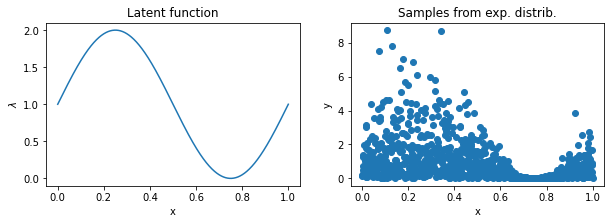

In [576]:
# Here we specify a 'true' latent function lambda
scale = lambda x: np.sin(2 * math.pi * x) + 1

# Generate synthetic data
# here we generate some synthetic samples
NSamp = 100

X = np.linspace(0, 1, 1000)

fig, (lambdaf, samples) = plt.subplots(1, 2, figsize=(10, 3))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')
rng = np.random.default_rng(2)
Y = np.zeros_like(X)
for i,x in enumerate(X):
    Y[i] = rng.exponential(scale(x), 1)
samples.scatter(X,Y)
samples.set_xlabel('x')
samples.set_ylabel('y')
samples.set_title('Samples from exp. distrib.')

In [577]:
train_x = torch.tensor(X).float()
train_y = torch.tensor(Y).float()

In [578]:
class PVGPRegressionModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_inducing=64, name_prefix="mixture_gp"):
        self.name_prefix = name_prefix

        # Define all the variational stuff
        inducing_points = torch.linspace(0, 1, num_inducing)
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points,
            gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=num_inducing)
        )

        # Standard initializtation
        super().__init__(variational_strategy)

        # Mean, covar, likelihood
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def guide(self, x, y):
        # Get q(f) - variational (guide) distribution of latent function
        function_dist = self.pyro_guide(x).to_event(1)
        
        # removing the plate notation, adding .to_event(1) makes each dimensions dependent
        res = pyro.sample(self.name_prefix + ".f(x)", function_dist)

    def model(self, x, y):
        pyro.module(self.name_prefix + ".gp", self)

        # Get p(f) - prior distribution of latent function
        function_dist = self.pyro_model(x).to_event(1)

        # removing the plate notation, adding .to_event(1) makes each dimensions dependent
        function_samples = pyro.sample(self.name_prefix + ".f(x)", function_dist)

        # Use the link function to convert GP samples into scale samples
        scale_samples = function_samples.exp()

        # Sample from observed distribution
        res = pyro.sample(
            self.name_prefix + ".y",
            # adding .to_event(1) makes each dimensions dependent
            pyro.distributions.Exponential(scale_samples.reciprocal()).to_event(1),  # rate = 1 / scale
            obs=y
        )

In [798]:
class PVGPRegressionModel(gpytorch.models.ApproximateGP):
    # def __init__(self, num_inducing=64, name_prefix="mixture_gp"):
    def __init__(self, inducing_points, name_prefix="mixture_gp"):
        self.name_prefix = name_prefix

        # Define all the variational stuff
        inducing_points = torch.linspace(0, 1, 64)
        
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=inducing_points.size(-1))
        
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        # Standard initializtation
        super().__init__(variational_strategy)

        # Mean, covar, likelihood
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def guide(self, x, y):
        # Get q(f) - variational (guide) distribution of latent function
        function_dist = self.pyro_guide(x)
        
        with pyro.plate(self.name_prefix + ".data_plate", size=len(x), dim=-1):
            # Sample from latent function distribution
            res = pyro.sample(self.name_prefix + ".f(x)", function_dist)

    def model(self, x, y):
        pyro.module(self.name_prefix + ".gp", self)

        # Get p(f) - prior distribution of latent function
        function_dist = self.pyro_model(x)

        # Use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", size=len(x), dim=-1):
            # Sample from latent function distribution
            function_samples = pyro.sample(self.name_prefix + ".f(x)", function_dist)
            
            # Use the link function to convert GP samples into scale samples
            scale_samples = function_samples.exp()

            # Sample from observed distribution
            res = pyro.sample(
                self.name_prefix + ".y",
                pyro.distributions.Exponential(scale_samples.reciprocal()),  # rate = 1 / scale
                obs=y
            )

In [784]:
class PVGPRegressionModel(gpytorch.models.ApproximateGP):
    # def __init__(self, num_inducing=64, name_prefix="mixture_gp"):
    def __init__(self, inducing_points, name_prefix="mixture_gp"):
        self.name_prefix = name_prefix

        # Define all the variational stuff
        # inducing_points = torch.linspace(0, 1, num_inducing)
        
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(num_inducing_points=inducing_points.size(-1))
        
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        # Standard initializtation
        super().__init__(variational_strategy)

        # Mean, covar, likelihood
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def guide(self, x, y):
        # Get q(f) - variational (guide) distribution of latent function
        function_dist = self.pyro_guide(x)
        
        with pyro.plate(self.name_prefix + ".data_plate", size=len(x), dim=-1):
            # Sample from latent function distribution
            res = pyro.sample(self.name_prefix + ".f(x)", function_dist)

    def model(self, x, y):
        global scale_samples
        global log_likelihood
        pyro.module(self.name_prefix + ".gp", self)

        # Get p(f) - prior distribution of latent function
        function_dist = self.pyro_model(x)

        # Use a plate here to mark conditional independencies
        with pyro.plate(self.name_prefix + ".data_plate", size=len(x), dim=-1):
            # Sample from latent function distribution
            function_samples = pyro.sample(self.name_prefix + ".f(x)", function_dist)
            
            # Use the link function to convert GP samples into scale samples
            scale_samples = function_samples.exp()

            # Sample from observed distribution
            # res = pyro.sample(
            #     self.name_prefix + ".y",
            #     pyro.distributions.Exponential(scale_samples.reciprocal()),  # rate = 1 / scale
            #     # obs=y
            # )
        
        log_likelihood = pyro.distributions.Exponential(scale_samples.reciprocal()).log_prob(y)
        pyro.factor(self.name_prefix + ".log_likelihood", log_likelihood.sum())

In [799]:
model = PVGPRegressionModel(inducing_points=train_x)

In [800]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_iter = 2 if smoke_test else 200
num_particles = 1 if smoke_test else 25

pyro.clear_param_store()

optimizer = pyro.optim.Adam({"lr": 0.1})
# elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
elbo = pyro.infer.Trace_ELBO(vectorize_particles=True, retain_graph=True)
svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter))
loss_list = []
for i in iterator:
    model.zero_grad()
    loss = svi.step(train_x, train_y)
    loss_list.append(loss)
    iterator.set_postfix(loss=loss, lengthscale=model.covar_module.base_kernel.lengthscale.item())

  0%|          | 0/200 [00:00<?, ?it/s]

In [765]:
dist.Exponential(scale_samples).log_prob(train_y).sum()

tensor(-1922.4065, grad_fn=<SumBackward0>)

In [766]:
dist.Exponential(scale_samples).to_event(1).log_prob(train_y)

tensor(-1922.4065, grad_fn=<SumBackward1>)

/home/cao/miniconda3/envs/pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

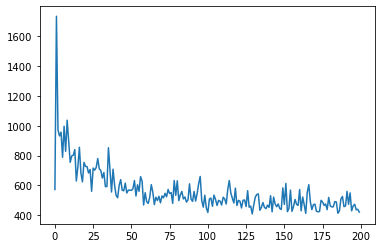

In [769]:
sns.lineplot(np.arange(0, len(loss_list)), loss_list)

In [770]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [771]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
test_x = torch.linspace(0, 1, denser * NSamp).float()#.cuda()

model.eval()
with torch.no_grad():
    output = model(test_x)

# Get E[exp(f)] via f_i ~ GP, 1/n \sum_{i=1}^{n} exp(f_i).
# Similarly get the 5th and 95th percentiles
samples = output(torch.Size([1000])).exp()
lower, mean, upper = percentiles_from_samples(samples)

# Draw some simulated y values
scale_sim = model(train_x)().exp()
y_sim = pyro.distributions.Exponential(scale_sim.reciprocal())()

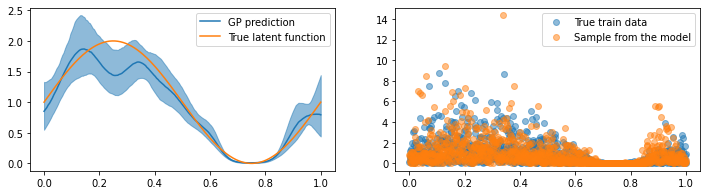

In [772]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean.detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower.detach().cpu().numpy(),
    upper.detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, scale(test_x), label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y, alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim.cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()